# Dialect Detection on RegSpeech12 (Bangla regional speech)  
**Pipeline:** wav2vec2 XLS-R embeddings → lightweight classifier

## Overview

This notebook implements an **embedding-based** dialect identification baseline using the **RegSpeech12** dataset from Kaggle (`mdrezuwanhassan/regspeech12`). Instead of fine-tuning a large speech model end-to-end, it uses a pretrained self-supervised model (**`wav2vec2-xls-r-300m`**) to generate audio embeddings and trains a small classifier on top. This keeps training fast, reproducible, and easy to deploy.

## Dataset assumptions (how labels are obtained)

The dataset is expected to have `train/`, `valid/`, and `test/` folders containing `.wav` files. Dialect labels are parsed from filenames using:

`^(train|valid|test)_(.+?)_(\d+)\.wav$`

For example, `train_<dialect>_<id>.wav` is treated as dialect `<dialect>`. If your files are named differently, update `TrainConfig.filename_regex`.

## Method

1. **Preprocess audio:** load WAV → convert to mono → resample to **16 kHz** (optional energy-based trimming removes leading/trailing silence).
2. **Chunk audio:** split each file into overlapping windows (default **4.0 s** chunks with **2.0 s** hop). Short clips are padded so every file yields at least one chunk.
3. **Extract embeddings:** run each chunk through wav2vec2 XLS-R and pool frame-level outputs into a fixed vector (`mean` pooling or `stats3` pooling = mean+std+max).
4. **Train a classifier:** learn a dialect classifier on chunk embeddings using either a linear SVM (`embed_linear_svc`) or XGBoost (`embed_xgboost`, if installed).
5. **Predict at file level:** average chunk-level scores/probabilities to produce a single prediction per audio file.

## Reproducibility and saved artifacts

Each run writes outputs into a timestamped folder under `artifacts/runs/`. The full configuration is saved to `config.json`, and embeddings can be cached to speed up reruns.

Common outputs in a run folder:

- `config.json` / `model_meta.json` — parameters needed to reproduce + run inference  
- `manifest.csv` — list of audio files, splits, and labels  
- `model.joblib` — trained classifier and fitted label encoder  
- `valid_report.txt`, `metrics.json`, `confusion_matrix.png` — validation evaluation outputs  
- `misclassified_valid.csv` — error analysis (high-confidence mistakes)  
- (optional) `test_predictions.csv`, `test_report.txt` — test-set evaluation outputs  

## How to run

1. Set `DATA_ROOT` to your extracted RegSpeech12 dataset directory.
2. Choose a strategy (`embed_linear_svc` is the recommended starting point).
3. Run cells top-to-bottom to train and validate.
4. Use the inference cells to predict a single file, a folder of files, or the test split.

## Notes and limitations

- Labels come from filenames; incorrect naming will produce incorrect labels.
- `LinearSVC` does not output calibrated probabilities. The notebook converts decision scores into softmax-style values that are useful for ranking, but they are not strict probability estimates.
- Dialect identification can encode dataset biases (recording conditions, speaker demographics). Treat results as a baseline and validate across diverse speakers and environments before using it in real applications.


### Cell 0 — Set paths, choose training strategy, and create a run directory

This cell sets the **dataset location** (`DATA_ROOT`) and creates a timestamped output folder (`RUN_DIR`) where all artifacts from this run will be saved.  

You also choose the training approach via `STRATEGY`:

- `embed_linear_svc`: wav2vec2 embeddings + a linear SVM (fast baseline)
- `embed_xgboost`: wav2vec2 embeddings + XGBoost (often stronger if available)

The rest of the notebook reads these settings from the config and writes outputs under `artifacts/runs/<run_name>/`.


In [2]:
from pathlib import Path
import time

# ✅ CHANGE THIS to your dataset root folder
DATA_ROOT = Path("/Users/farhanaakter/Downloads/archive-3").expanduser()

# Where all outputs will be saved (models, reports, confusion matrix, cache)
PROJECT_ROOT = Path(".").resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
RUNS_DIR = ARTIFACTS_DIR / "runs"

# Choose one:
# "embed_linear_svc"  (fast baseline)
# "embed_xgboost"     (strong baseline if xgboost installed)
# "finetune"          (best quality, slower)
STRATEGY = "embed_linear_svc"

RUN_NAME = time.strftime("%Y%m%d_%H%M%S") + "_" + STRATEGY
RUN_DIR = RUNS_DIR / RUN_NAME
RUN_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)
print("RUN_DIR:", RUN_DIR)


DATA_ROOT: /Users/farhanaakter/Downloads/archive-3
RUN_DIR: /Users/farhanaakter/Pictures/ProjectML/artifacts/runs/20260217_213632_embed_linear_svc


### Cell 1 — Import dependencies

Imports the Python packages used across the notebook: standard utilities (paths, JSON, math, etc.), audio IO/resampling (`soundfile`, `torchaudio`), the pretrained wav2vec2 model via Hugging Face `transformers`, and the classical ML stack from `scikit-learn`.

If XGBoost is installed, it is imported as an optional classifier backend; otherwise the notebook continues with the SVM strategy.


In [ ]:
import os
import re
import json
import math
import random
import hashlib
from dataclasses import dataclass, asdict
from typing import List, Tuple

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import soundfile as sf

import torch
import torchaudio

from transformers import (
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Model,
    Wav2Vec2ForSequenceClassification,
)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import joblib
import matplotlib.pyplot as plt

try:
    import xgboost as xgb
except Exception:
    xgb = None


### Cell 2 — Define `TrainConfig` and save the run configuration

Defines a single configuration object (`TrainConfig`) that centralizes the notebook’s key choices: how labels are parsed from filenames, audio preprocessing and chunking settings, which wav2vec2 model to use, pooling type, and which classifier strategy to train.

At the end of the cell, the instantiated config is written to `RUN_DIR/config.json` so the run can be reproduced later (including for test evaluation and inference).


In [4]:
@dataclass
class TrainConfig:
    project_root: str = "."
    data_root: str = ""
    artifacts_dir: str = "artifacts"
    run_name: str = ""

    filename_regex: str = r"^(train|valid|test)_(.+?)_(\d+)\.wav$"

    target_sr: int = 16000
    chunk_sec: float = 4.0
    hop_sec: float = 2.0
    max_chunks_per_file_train: int = 6
    max_chunks_per_file_eval: int = 10
    trim_silence: bool = True
    trim_db: float = 35.0

    ssl_model_name: str = "facebook/wav2vec2-xls-r-300m"
    pooling: str = "stats3"          # "mean" or "stats3"
    cache_embeddings: bool = True

    strategy: str = "embed_linear_svc"  # "embed_linear_svc" | "embed_xgboost" | "finetune"

    # XGBoost
    xgb_n_estimators: int = 800
    xgb_max_depth: int = 8
    xgb_learning_rate: float = 0.05
    xgb_subsample: float = 0.9
    xgb_colsample: float = 0.9

    # Fine-tune
    ft_epochs: int = 6
    ft_batch_size: int = 8
    ft_lr: float = 2e-5
    ft_weight_decay: float = 0.01
    ft_warmup_ratio: float = 0.05
    ft_freeze_feature_encoder: bool = True
    ft_grad_accum_steps: int = 1
    ft_amp: bool = True

    # Augmentation (fine-tune)
    aug_speed_probs: float = 0.35
    aug_noise_probs: float = 0.40
    aug_gain_probs: float = 0.30
    aug_speeds: Tuple[float, float, float] = (0.9, 1.0, 1.1)
    aug_snr_db_range: Tuple[float, float] = (10.0, 30.0)
    aug_gain_range: Tuple[float, float] = (0.8, 1.2)

    seed: int = 7


cfg = TrainConfig(
    project_root=str(PROJECT_ROOT),
    data_root=str(DATA_ROOT),
    strategy=STRATEGY,
    run_name=RUN_NAME,
)

# Save config to run folder
(RUN_DIR / "config.json").write_text(json.dumps(asdict(cfg), indent=2))
print("Saved config:", RUN_DIR / "config.json")


Saved config: /Users/farhanaakter/Pictures/ProjectML/artifacts/runs/20260217_213632_embed_linear_svc/config.json


### Cell 3 — Utility functions (reproducibility, audio preprocessing, plotting)

This cell defines the helper functions used throughout training, evaluation, and inference. Keeping them in one place makes the pipeline easier to follow and reuse.

Key helpers include:

- **Reproducibility / environment:** `set_seed`, `get_device`
- **Audio loading and cleanup:** `load_audio_mono`, `trim_silence_energy`
- **Chunking:** `make_chunks`, `sample_chunks`
- **Caching / bookkeeping:** `sha1`
- **Visualization:** `plot_confusion`

The cell also sets a global random seed and selects the compute device (`cuda` / `mps` / `cpu`).


In [5]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_device() -> str:
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"

def sha1(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()[:16]

def load_audio_mono(path: str, target_sr: int) -> torch.Tensor:
    wav, sr = sf.read(path, always_2d=True)
    wav = wav.mean(axis=1)
    wav_t = torch.tensor(wav, dtype=torch.float32)
    if sr != target_sr:
        wav_t = torchaudio.functional.resample(wav_t, sr, target_sr)
    return wav_t

def trim_silence_energy(wav: torch.Tensor, sr: int, trim_db: float) -> torch.Tensor:
    if wav.numel() < sr // 2:
        return wav
    frame = int(sr * 0.02)
    hop = int(sr * 0.01)
    x = wav.unsqueeze(0)
    frames = x.unfold(1, frame, hop)
    rms = torch.sqrt(torch.mean(frames ** 2, dim=-1) + 1e-9).squeeze(0)
    rms_db = 20 * torch.log10(rms + 1e-9)
    thr = rms_db.max() - trim_db
    keep = (rms_db >= thr).nonzero(as_tuple=False).squeeze(-1)
    if keep.numel() == 0:
        return wav
    start = int(keep.min().item()) * hop
    end = min(wav.numel(), int(keep.max().item()) * hop + frame)
    return wav[start:end]

def make_chunks(wav: torch.Tensor, sr: int, chunk_sec: float, hop_sec: float) -> List[torch.Tensor]:
    chunk = int(sr * chunk_sec)
    hop = int(sr * hop_sec)
    if wav.numel() <= chunk:
        return [torch.nn.functional.pad(wav, (0, chunk - wav.numel()))]
    out = []
    for start in range(0, wav.numel() - chunk + 1, hop):
        out.append(wav[start:start+chunk])
    return out if out else [wav[:chunk]]

def sample_chunks(chunks: List[torch.Tensor], k: int, seed: int) -> List[torch.Tensor]:
    if len(chunks) <= k:
        return chunks
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(chunks), size=k, replace=False)
    return [chunks[i] for i in idx]

def plot_confusion(cm: np.ndarray, labels: List[str], out_png: Path):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title("Confusion Matrix")
    plt.colorbar(im, ax=ax)
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    plt.tight_layout()
    fig.savefig(out_png, dpi=160)
    plt.close(fig)

set_seed(cfg.seed)
DEVICE = get_device()
print("DEVICE:", DEVICE)


DEVICE: mps


### Cell 4 — Build a dataset manifest (`train`/`valid`/`test`) and inspect label distribution

Here the notebook scans the dataset directories, extracts the dialect label for each `.wav` file using `cfg.filename_regex`, and assembles a single manifest table with the file path, split name, and dialect label.

The manifest is saved to `RUN_DIR/manifest.csv`. This becomes the “source of truth” for which files are used in training/validation/testing, and it also makes it easy to audit class balance before training.


In [6]:
def find_split_dir(base: Path, split: str) -> Path:
    for p in base.rglob(split):
        if p.is_dir() and any(p.glob("*.wav")):
            return p
    raise FileNotFoundError(f"Could not find '{split}' folder with wavs under {base}")

def build_manifest(data_root: Path, filename_regex: str) -> pd.DataFrame:
    rgx = re.compile(filename_regex)
    train_dir = find_split_dir(data_root, "train")
    valid_dir = find_split_dir(data_root, "valid")
    test_dir  = find_split_dir(data_root, "test")

    def list_wavs(split_name: str, split_dir: Path) -> pd.DataFrame:
        rows = []
        for p in sorted(split_dir.glob("*.wav")):
            fn = p.name
            m = rgx.match(fn)
            dialect = m.group(2) if m else "unknown"
            rows.append({"path": str(p), "file": fn, "split": split_name, "dialect": dialect})
        return pd.DataFrame(rows)

    df = pd.concat(
        [list_wavs("train", train_dir), list_wavs("valid", valid_dir), list_wavs("test", test_dir)],
        ignore_index=True,
    )
    return df

df = build_manifest(DATA_ROOT, cfg.filename_regex)
(df.to_csv(RUN_DIR / "manifest.csv", index=False))
print("Saved manifest:", RUN_DIR / "manifest.csv")

print("Total clips:", len(df))
print("Dialects:", df["dialect"].nunique())
display(df["dialect"].value_counts())


Saved manifest: /Users/farhanaakter/Pictures/ProjectML/artifacts/runs/20260217_213632_embed_linear_svc/manifest.csv
Total clips: 21313
Dialects: 12


dialect
sylhet         7624
kishoreganj    2049
narail         1859
chittagong     1757
narsingdi      1373
sandwip        1310
rangpur        1298
tangail        1271
habiganj       1170
barishal       1006
comilla         318
noakhali        278
Name: count, dtype: int64

### Cell 5 — wav2vec2 embedding pipeline + caching

This cell defines the embedding stage. Each audio file is converted into one or more **fixed-length chunks**, and each chunk is encoded by the pretrained wav2vec2 XLS-R model into a fixed-dimensional vector.

Two pooling modes are supported:

- `mean`: average over time (compact baseline)
- `stats3`: concatenate mean + standard deviation + max (richer representation)

To make iteration faster, chunk embeddings can be cached under `RUN_DIR/cache/` using a stable hash of the embedding settings. If the cache exists, it is loaded instead of recomputing embeddings.


In [ ]:
class SSLEncoder:
    def __init__(self, model_name: str, device: str, target_sr: int, pooling: str):
        self.device = device
        self.target_sr = target_sr
        self.pooling = pooling
        self.processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
        self.model = Wav2Vec2Model.from_pretrained(model_name).to(device)
        self.model.eval()

    @torch.no_grad()
    def encode_chunk(self, wav_chunk: torch.Tensor) -> np.ndarray:
        inputs = self.processor(
            wav_chunk.numpy(),
            sampling_rate=self.target_sr,
            return_tensors="pt",
            padding=True,
        )
        x = inputs["input_values"].to(self.device)
        h = self.model(x).last_hidden_state.squeeze(0)

        if self.pooling == "mean":
            emb = h.mean(dim=0)
            return emb.cpu().numpy().astype(np.float32)

        if self.pooling == "stats3":
            mu = h.mean(dim=0)
            sd = h.std(dim=0)
            mx = h.max(dim=0).values
            emb = torch.cat([mu, sd, mx], dim=0)
            return emb.cpu().numpy().astype(np.float32)

        raise ValueError("pooling must be 'mean' or 'stats3'")

def embed_dataset_chunks(cfg: TrainConfig, df: pd.DataFrame, split: str, encoder: SSLEncoder, cache_dir: Path, seed_offset: int):
    df_split = df[df["split"] == split].reset_index(drop=True)

    key = sha1(json.dumps(
        {
            "model": cfg.ssl_model_name,
            "pooling": cfg.pooling,
            "split": split,
            "chunk_sec": cfg.chunk_sec,
            "hop_sec": cfg.hop_sec,
            "max_chunks": cfg.max_chunks_per_file_train if split == "train" else cfg.max_chunks_per_file_eval,
            "trim": cfg.trim_silence,
            "trim_db": cfg.trim_db,
            "data_root": str(Path(cfg.data_root).resolve()),
        },
        sort_keys=True
    ))
    cache_path = cache_dir / f"emb_{key}.npz"

    if cfg.cache_embeddings and cache_path.exists():
        z = np.load(cache_path, allow_pickle=True)
        return z["X"], z["y"], z["file_ids"]

    X_list, y_list, file_list = [], [], []
    max_chunks = cfg.max_chunks_per_file_train if split == "train" else cfg.max_chunks_per_file_eval

    for i, r in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Embedding {split}"):
        wav = load_audio_mono(r["path"], cfg.target_sr)
        if cfg.trim_silence:
            wav = trim_silence_energy(wav, cfg.target_sr, cfg.trim_db)

        chunks = make_chunks(wav, cfg.target_sr, cfg.chunk_sec, cfg.hop_sec)
        chunks = sample_chunks(chunks, max_chunks, seed=cfg.seed + seed_offset + i)

        for c in chunks:
            X_list.append(encoder.encode_chunk(c))
            y_list.append(r["dialect"])
            file_list.append(r["path"])

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list)
    file_ids = np.array(file_list)

    if cfg.cache_embeddings:
        np.savez_compressed(cache_path, X=X, y=y, file_ids=file_ids)

    return X, y, file_ids

def aggregate_probs_by_file(file_ids: np.ndarray, probs: np.ndarray):
    dfp = pd.DataFrame({"file": file_ids})
    for j in range(probs.shape[1]):
        dfp[f"p{j}"] = probs[:, j]
    grp = dfp.groupby("file", sort=False).mean(numeric_only=True).reset_index()
    files = grp["file"].values
    pcols = [c for c in grp.columns if c.startswith("p")]
    return files, grp[pcols].values

CACHE_DIR = (RUN_DIR / "cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

encoder = SSLEncoder(cfg.ssl_model_name, DEVICE, cfg.target_sr, cfg.pooling)
print("Encoder ready.")


### Cell 6 — Train an embedding-based classifier and save all run artifacts

This is the core training/evaluation cell.

The workflow is:

1. Embed the **train** and **valid** splits into chunk-level vectors.
2. Fit a `LabelEncoder` so dialect strings map to consistent class IDs.
3. Train the chosen classifier (`embed_linear_svc` or `embed_xgboost`) on chunk embeddings.
4. Convert chunk predictions to **file-level** predictions by averaging chunk-level class probabilities.
5. Evaluate on the validation split and save run artifacts.

Artifacts saved in `RUN_DIR/` include the trained model (`model.joblib`), metadata needed for inference (`model_meta.json`), and validation outputs (report, metrics, confusion matrix, and a table of misclassified examples).


In [ ]:
def train_embed_model(cfg: TrainConfig, df: pd.DataFrame, run_dir: Path):
    Xtr, ytr, ftr = embed_dataset_chunks(cfg, df, "train", encoder, CACHE_DIR, seed_offset=100)
    Xva, yva, fva = embed_dataset_chunks(cfg, df, "valid", encoder, CACHE_DIR, seed_offset=200)

    le = LabelEncoder()
    ytr_i = le.fit_transform(ytr)
    yva_i = le.transform(yva)
    labels = list(le.classes_)
    n_classes = len(labels)

    if cfg.strategy == "embed_linear_svc":
        clf = Pipeline([("scaler", StandardScaler()),
                        ("svc", LinearSVC(class_weight="balanced"))])
        clf.fit(Xtr, ytr_i)

        dec = clf.decision_function(Xva)
        if dec.ndim == 1:
            dec = np.stack([-dec, dec], axis=1)
        probs_chunks = np.exp(dec - dec.max(axis=1, keepdims=True))
        probs_chunks = probs_chunks / probs_chunks.sum(axis=1, keepdims=True)

    elif cfg.strategy == "embed_xgboost":
        if xgb is None:
            raise RuntimeError("xgboost not installed. Install with: pip install xgboost")

        counts = np.bincount(ytr_i, minlength=n_classes)
        inv = counts.max() / np.maximum(counts, 1)
        w = inv[ytr_i].astype(np.float32)

        clf = xgb.XGBClassifier(
            n_estimators=cfg.xgb_n_estimators,
            max_depth=cfg.xgb_max_depth,
            learning_rate=cfg.xgb_learning_rate,
            subsample=cfg.xgb_subsample,
            colsample_bytree=cfg.xgb_colsample,
            objective="multi:softprob",
            num_class=n_classes,
            eval_metric="mlogloss",
            tree_method="hist",
        )
        clf.fit(Xtr, ytr_i, sample_weight=w, eval_set=[(Xva, yva_i)], verbose=False, early_stopping_rounds=50)
        probs_chunks = clf.predict_proba(Xva)
    else:
        raise ValueError("strategy must be embed_linear_svc or embed_xgboost")

    # aggregate chunk probs -> file probs
    files_va, probs_va = aggregate_probs_by_file(fva, probs_chunks)

    # map each file -> true label
    valid_map = df[df["split"] == "valid"].set_index("path")["dialect"].to_dict()
    yva_file = np.array([valid_map[f] for f in files_va])
    yva_file_i = le.transform(yva_file)

    pred_i = probs_va.argmax(axis=1)
    acc = accuracy_score(yva_file_i, pred_i)
    f1m = f1_score(yva_file_i, pred_i, average="macro")

    report = classification_report(yva_file_i, pred_i, target_names=labels, digits=4)
    cm = confusion_matrix(yva_file_i, pred_i)

    (run_dir / "valid_report.txt").write_text(report)
    (run_dir / "metrics.json").write_text(json.dumps({"valid_accuracy": float(acc), "valid_macro_f1": float(f1m)}, indent=2))
    plot_confusion(cm, labels, run_dir / "confusion_matrix.png")

    miss = pd.DataFrame({
        "file": files_va,
        "true": le.inverse_transform(yva_file_i),
        "pred": le.inverse_transform(pred_i),
        "confidence": probs_va.max(axis=1),
    })
    miss = miss[miss["true"] != miss["pred"]].sort_values("confidence", ascending=False)
    miss.to_csv(run_dir / "misclassified_valid.csv", index=False)

    joblib.dump({"model": clf, "label_encoder": le}, run_dir / "model.joblib")
    (run_dir / "model_meta.json").write_text(json.dumps({
        "strategy": cfg.strategy,
        "ssl_model_name": cfg.ssl_model_name,
        "pooling": cfg.pooling,
        "target_sr": cfg.target_sr,
        "chunk_sec": cfg.chunk_sec,
        "hop_sec": cfg.hop_sec,
        "max_chunks_eval": cfg.max_chunks_per_file_eval,
    }, indent=2))

    print("✅ Saved run:", run_dir)
    print("Valid accuracy:", acc)
    print("Valid macro-F1 :", f1m)
    return acc, f1m

# Run it
if cfg.strategy.startswith("embed_"):
    train_embed_model(cfg, df, RUN_DIR)
else:
    print("Set STRATEGY to embed_linear_svc or embed_xgboost for this cell.")


### Cell 7 — Inspect a saved run (reports + common mistakes)

Loads the outputs from a completed run folder.



In [10]:
from pathlib import Path
import pandas as pd

RUN_DIR = Path("/Users/farhanaakter/ProjectML/artifacts/runs/20260209_183210_embed_linear_svc")

print("Files in run dir:")
for p in sorted(RUN_DIR.glob("*")):
    print(" -", p.name)






Files in run dir:
 - .DS_Store
 - batch_errors.csv
 - batch_predictions.csv
 - confusion_matrix.png
 - manifest.csv
 - metrics.json
 - misclassified_valid.csv
 - model.joblib
 - model_meta.json
 - test_confusion_matrix.csv
 - test_predictions.csv
 - test_report.txt
 - valid_report.txt


### Cell 8 — Single-file inference helper: `predict_from_run_dir(...)`

Defines a compact inference helper that can run predictions from a saved `RUN_DIR` (so you can ship the trained run folder and reuse it without retraining).

The function loads the saved classifier and label encoder (`model.joblib`) plus the embedding settings (`model_meta.json`), embeds the input WAV in chunks using wav2vec2, averages chunk-level scores into a single file-level prediction, and returns the predicted dialect label along with a confidence value and the top-ranked alternatives.


In [ ]:
import json
from pathlib import Path
from typing import List, Tuple

import numpy as np
import torch
import torchaudio
import soundfile as sf
import joblib
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

def load_audio_mono(path: str, target_sr: int) -> torch.Tensor:
    wav, sr = sf.read(path, always_2d=True)
    wav = wav.mean(axis=1)
    wav_t = torch.tensor(wav, dtype=torch.float32)
    if sr != target_sr:
        wav_t = torchaudio.functional.resample(wav_t, sr, target_sr)
    return wav_t

def make_chunks(wav: torch.Tensor, sr: int, chunk_sec: float, hop_sec: float) -> List[torch.Tensor]:
    chunk = int(sr * chunk_sec)
    hop = int(sr * hop_sec)
    if wav.numel() <= chunk:
        pad = chunk - wav.numel()
        return [torch.nn.functional.pad(wav, (0, pad))]
    out = []
    for start in range(0, wav.numel() - chunk + 1, hop):
        out.append(wav[start:start+chunk])
    return out if out else [wav[:chunk]]

def softmax_np(x: np.ndarray) -> np.ndarray:
    x = x - x.max(axis=1, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=1, keepdims=True)

@torch.no_grad()
def predict_from_run_dir(run_dir: Path, wav_path: str):
    meta = json.loads((run_dir / "model_meta.json").read_text())
    target_sr = meta["target_sr"]
    chunk_sec = meta["chunk_sec"]
    hop_sec = meta["hop_sec"]
    max_chunks = meta["max_chunks_eval"]
    ssl_name = meta["ssl_model_name"]
    pooling = meta["pooling"]

    pack = joblib.load(run_dir / "model.joblib")
    model = pack["model"]
    le = pack["label_encoder"]
    labels = list(le.classes_)

    device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

    fe = Wav2Vec2FeatureExtractor.from_pretrained(ssl_name)
    ssl = Wav2Vec2Model.from_pretrained(ssl_name).to(device).eval()

    wav = load_audio_mono(wav_path, target_sr)
    chunks = make_chunks(wav, target_sr, chunk_sec, hop_sec)[:max_chunks]

    X = []
    for c in chunks:
        inputs = fe(c.numpy(), sampling_rate=target_sr, return_tensors="pt", padding=True)
        x = inputs["input_values"].to(device)
        h = ssl(x).last_hidden_state.squeeze(0)

        if pooling == "mean":
            emb = h.mean(dim=0)
        else:
            mu = h.mean(dim=0)
            sd = h.std(dim=0)
            mx = h.max(dim=0).values
            emb = torch.cat([mu, sd, mx], dim=0)

        X.append(emb.cpu().numpy().astype(np.float32))

    X = np.stack(X)

    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)
    else:
        dec = model.decision_function(X)
        if dec.ndim == 1:
            dec = np.stack([-dec, dec], axis=1)
        probs = softmax_np(dec)

    p = probs.mean(axis=0)
    pred_i = int(p.argmax())
    pred_label = labels[pred_i]
    conf = float(p[pred_i])

    top5 = np.argsort(-p)[:5]
    top5_labels = [(labels[i], float(p[i])) for i in top5]
    return pred_label, conf, top5_labels


### Cell 9 — Pick a sample WAV file to test inference

Finds `.wav` files under a chosen folder and selects one as `AUDIO_PATH` for a quick end-to-end inference check.


In [ ]:
from pathlib import Path

proj = Path("/Users/farhanaakter/ProjectML")
hits = sorted(proj.rglob("*.wav"))

print("Found wavs:", len(hits))
for i, p in enumerate(hits[:22]):
    print(i, p)

AUDIO_PATH = str(hits[0])   # pick index 0 for now
print("Using:", AUDIO_PATH)


Found wavs: 22
0 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-1234Hz-le-1ch-10S-20bit-extra.wav
1 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-44100Hz-2ch-32bit-float-be.wav
2 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-44100Hz-2ch-32bit-float-le.wav
3 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-44100Hz-be-1ch-4bytes.wav
4 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-44100Hz-le-1ch-4bytes-early-eof-no-data.wav
5 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-44100Hz-le-1ch-4bytes-early-eof.wav
6 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-44100Hz-le-1ch-4bytes-incomplete-chunk.wav
7 /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/test

### Cell 10 — Sanity check the chosen audio path

Verifies that the selected `AUDIO_PATH` exists before attempting inference.


In [ ]:
from pathlib import Path
print(Path(AUDIO_PATH).exists(), AUDIO_PATH)


True /Users/farhanaakter/ProjectML/makhtom/lib/python3.12/site-packages/scipy/io/tests/data/test-1234Hz-le-1ch-10S-20bit-extra.wav


### Cell 11 — Run a single prediction and print results

Runs `predict_from_run_dir(RUN_DIR, AUDIO_PATH)` and prints the predicted dialect label along with a confidence score and the top-5 class probabilities.


In [ ]:
pred, conf, top5 = predict_from_run_dir(RUN_DIR, AUDIO_PATH)
print("Prediction:", pred)
print("Confidence:", conf)
print("Top-5:", top5)


Loading weights: 100%|██████████| 422/422 [00:00<00:00, 1474.92it/s, Materializing param=masked_spec_embed]                                            
Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-xls-r-300m
Key                          | Status     |  | 
-----------------------------+------------+--+-
project_hid.weight           | UNEXPECTED |  | 
project_q.weight             | UNEXPECTED |  | 
quantizer.codevectors        | UNEXPECTED |  | 
quantizer.weight_proj.weight | UNEXPECTED |  | 
quantizer.weight_proj.bias   | UNEXPECTED |  | 
project_q.bias               | UNEXPECTED |  | 
project_hid.bias             | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Prediction: sandwip
Confidence: 0.9597424857476411
Top-5: [(np.str_('sandwip'), 0.9597424857476411), (np.str_('comilla'), 0.038486076384847794), (np.str_('kishoreganj'), 0.0010480305419870834), (np.str_('sylhet'), 0.0007013961193445033), (np.str_('narsingdi'), 1.301108348414011e-05)]


### Cell 12 — Locate the dataset test split from the saved config

Reloads `RUN_DIR/config.json` to recover the dataset root used during training, then searches for the corresponding `test/` directory (the one that actually contains `.wav` files).

This makes test evaluation less error-prone when you revisit an old run later.


In [ ]:
from pathlib import Path
import json

RUN_DIR = Path("/Users/farhanaakter/ProjectML/artifacts/runs/20260209_183210_embed_linear_svc")

cfg = json.loads((RUN_DIR / "config.json").read_text())
DATA_ROOT = Path(cfg["data_root"])
print("DATA_ROOT from training:", DATA_ROOT)

# find the real test folder (the one with wavs)
test_dir = None
for p in DATA_ROOT.rglob("test"):
    if p.is_dir() and any(p.glob("*.wav")):
        test_dir = p
        break

print("test_dir:", test_dir)
wav_files = sorted(test_dir.glob("*.wav")) if test_dir else []
print("test wav count:", len(wav_files))
print("example:", wav_files[:5])


DATA_ROOT from training: /Users/farhanaakter/Downloads/archive-3
test_dir: /Users/farhanaakter/Downloads/archive-3/test
test wav count: 2132
example: [PosixPath('/Users/farhanaakter/Downloads/archive-3/test/test_barishal_0001.wav'), PosixPath('/Users/farhanaakter/Downloads/archive-3/test/test_barishal_0002.wav'), PosixPath('/Users/farhanaakter/Downloads/archive-3/test/test_barishal_0003.wav'), PosixPath('/Users/farhanaakter/Downloads/archive-3/test/test_barishal_0004.wav'), PosixPath('/Users/farhanaakter/Downloads/archive-3/test/test_barishal_0005.wav')]


### Cell 13 — `EmbedPredictor`: faster repeated inference (caches models in memory)

Defines an inference class intended for **many-file** prediction. Unlike `predict_from_run_dir`, it loads wav2vec2 and the classifier only once, then reuses them across calls.

Internally it keeps:
- the trained classifier + label encoder
- the wav2vec2 feature extractor and model
- the chunking/embedding parameters from `model_meta.json`


In [ ]:
import json
import numpy as np
import torch
import joblib
from pathlib import Path
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from transformers.utils import logging as hf_logging

hf_logging.set_verbosity_error()  # hides the repeated load reports

class EmbedPredictor:
    def __init__(self, run_dir: Path):
        self.run_dir = Path(run_dir)
        self.meta = json.loads((self.run_dir / "model_meta.json").read_text())

        pack = joblib.load(self.run_dir / "model.joblib")
        self.clf = pack["model"]
        self.le  = pack["label_encoder"]
        self.labels = list(self.le.classes_)

        self.target_sr = self.meta["target_sr"]
        self.chunk_sec = self.meta["chunk_sec"]
        self.hop_sec   = self.meta["hop_sec"]
        self.max_chunks = self.meta["max_chunks_eval"]
        self.ssl_name  = self.meta["ssl_model_name"]
        self.pooling   = self.meta["pooling"]

        self.device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
        self.fe = Wav2Vec2FeatureExtractor.from_pretrained(self.ssl_name)
        self.ssl = Wav2Vec2Model.from_pretrained(self.ssl_name).to(self.device).eval()

    def _softmax_np(self, x):
        x = x - x.max(axis=1, keepdims=True)
        e = np.exp(x)
        return e / e.sum(axis=1, keepdims=True)

    @torch.no_grad()
    def predict(self, wav_path: str):
        wav = load_audio_mono(wav_path, self.target_sr)
        chunks = make_chunks(wav, self.target_sr, self.chunk_sec, self.hop_sec)[:self.max_chunks]

        X = []
        for c in chunks:
            inputs = self.fe(c.numpy(), sampling_rate=self.target_sr, return_tensors="pt", padding=True)
            x = inputs["input_values"].to(self.device)
            h = self.ssl(x).last_hidden_state.squeeze(0)

            if self.pooling == "mean":
                emb = h.mean(dim=0)
            else:
                mu = h.mean(dim=0)
                sd = h.std(dim=0)
                mx = h.max(dim=0).values
                emb = torch.cat([mu, sd, mx], dim=0)

            X.append(emb.cpu().numpy().astype(np.float32))

        X = np.stack(X)

        if hasattr(self.clf, "predict_proba"):
            probs = self.clf.predict_proba(X)
        else:
            dec = self.clf.decision_function(X)
            if dec.ndim == 1:
                dec = np.stack([-dec, dec], axis=1)
            probs = self._softmax_np(dec)

        p = probs.mean(axis=0)
        pred_i = int(p.argmax())
        pred = self.labels[pred_i]
        conf = float(p[pred_i])
        top5_idx = np.argsort(-p)[:5]
        top5 = [(self.labels[i], float(p[i])) for i in top5_idx]
        return pred, conf, top5


### Cell 14 — Predict the entire test set and save `test_predictions.csv`

Uses `EmbedPredictor` to run inference over all files in the dataset’s `test/` split and saves per-file predictions to `RUN_DIR/test_predictions.csv`.


In [ ]:
from pathlib import Path
import pandas as pd

predictor = EmbedPredictor(RUN_DIR)

wav_files = sorted(Path(json.loads((RUN_DIR/"config.json").read_text())["data_root"]).rglob("test/*.wav"))
print("Test wavs:", len(wav_files))

rows = []
for wp in wav_files:
    pred, conf, top5 = predictor.predict(str(wp))
    rows.append({"file": str(wp), "pred": pred, "confidence": conf, "top5": top5})

df = pd.DataFrame(rows)
df.to_csv(RUN_DIR / "test_predictions.csv", index=False)
df.head()


### Cell 15 — Evaluate test predictions (accuracy, macro-F1, report, confusion matrix)

Evaluates `test_predictions.csv` against the ground-truth dialect labels parsed from filenames. It computes standard metrics (accuracy and macro-F1) and writes a full classification report plus a confusion matrix to the run folder.

Files with labels not seen during training are filtered out to keep evaluation consistent with the trained label set.


In [ ]:
import re, json
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 1) Load test_predictions.csv you just saved
df = pd.read_csv(RUN_DIR / "test_predictions.csv")

# 2) Extract true label from filename like: test_<dialect>_<id>.wav
rgx = re.compile(r"^(train|valid|test)_(.+?)_(\d+)\.wav$", re.IGNORECASE)
df["true"] = df["file"].apply(lambda s: rgx.match(Path(s).name).group(2) if rgx.match(Path(s).name) else "unknown")

# 3) Use the label encoder from your run (ensures consistent class order)
pack = joblib.load(RUN_DIR / "model.joblib")
le = pack["label_encoder"]
known = set(le.classes_)

# keep only rows whose true label exists in training classes
dfk = df[df["true"].isin(known)].copy()

yt = le.transform(dfk["true"])
yp = le.transform(dfk["pred"])

acc = accuracy_score(yt, yp)
f1m = f1_score(yt, yp, average="macro")
print("TEST accuracy:", acc)
print("TEST macro-F1 :", f1m)

report = classification_report(yt, yp, target_names=list(le.classes_), digits=4)
print("\n", report)

# optional: save report + confusion matrix data
(RUN_DIR / "test_report.txt").write_text(report)
pd.DataFrame(confusion_matrix(yt, yp), index=le.classes_, columns=le.classes_).to_csv(RUN_DIR / "test_confusion_matrix.csv")

# show worst mistakes (high-confidence wrong predictions)
dfk["wrong"] = dfk["true"] != dfk["pred"]
dfk[dfk["wrong"]].sort_values("confidence", ascending=False).head(25)[["file","true","pred","confidence"]]


TEST accuracy: 0.7884615384615384
TEST macro-F1 : 0.65614674707904

               precision    recall  f1-score   support

    barishal     0.8673    0.9703    0.9159       101
  chittagong     0.7919    0.9943    0.8816       176
     comilla     0.2727    0.0938    0.1395        32
    habiganj     0.8723    0.3504    0.5000       117
 kishoreganj     0.9900    0.9707    0.9803       205
      narail     0.7155    0.4462    0.5497       186
   narsingdi     0.8333    0.2190    0.3468       137
    noakhali     0.7500    0.2143    0.3333        28
     rangpur     0.8667    1.0000    0.9286       130
     sandwip     0.9359    0.5573    0.6986       131
      sylhet     0.7204    0.9908    0.8343       762
     tangail     0.8544    0.6929    0.7652       127

    accuracy                         0.7885      2132
   macro avg     0.7892    0.6250    0.6561      2132
weighted avg     0.7982    0.7885    0.7579      2132



,file,true,pred,confidence
803,/Users/farhanaakter/Downloads/archive-3/test/t...,narail,rangpur,0.974899
967,/Users/farhanaakter/Downloads/archive-3/test/t...,noakhali,barishal,0.924424
738,/Users/farhanaakter/Downloads/archive-3/test/t...,narail,sylhet,0.860124
284,/Users/farhanaakter/Downloads/archive-3/test/t...,comilla,sylhet,0.858648
795,/Users/farhanaakter/Downloads/archive-3/test/t...,narail,rangpur,0.856380
330,/Users/farhanaakter/Downloads/archive-3/test/t...,habiganj,comilla,0.788095
1607,/Users/farhanaakter/Downloads/archive-3/test/t...,sylhet,habiganj,0.784963
799,/Users/farhanaakter/Downloads/archive-3/test/t...,narail,rangpur,0.784427
283,/Users/farhanaakter/Downloads/archive-3/test/t...,comilla,sylhet,0.777286
350,/Users/farhanaakter/Downloads/archive-3/test/t...,habiganj,narail,0.766795


### Cell 16 — Quick qualitative sanity check of predictions

Prints a small random sample of test rows with `(true, predicted, confidence)` to spot obvious issues (e.g., systematically low confidence or repeated confusions).


In [ ]:
import pandas as pd
import re
from pathlib import Path

RUN_DIR = Path("/Users/farhanaakter/ProjectML/artifacts/runs/20260209_183210_embed_linear_svc")

df = pd.read_csv(RUN_DIR / "test_predictions.csv")

rgx = re.compile(r"^(train|valid|test)_(.+?)_(\d+)\.wav$", re.IGNORECASE)
df["true"] = df["file"].apply(lambda s: rgx.match(Path(s).name).group(2) if rgx.match(Path(s).name) else "unknown")

dfk = df.copy()  # or filter known labels if you want
dfk.sample(25)[["file","true","pred","confidence"]]


,file,true,pred,confidence
520,/Users/farhanaakter/Downloads/archive-3/test/t...,kishoreganj,kishoreganj,0.972490
596,/Users/farhanaakter/Downloads/archive-3/test/t...,kishoreganj,kishoreganj,0.939882
1620,/Users/farhanaakter/Downloads/archive-3/test/t...,sylhet,sylhet,0.983059
440,/Users/farhanaakter/Downloads/archive-3/test/t...,kishoreganj,kishoreganj,0.941763
1638,/Users/farhanaakter/Downloads/archive-3/test/t...,sylhet,sylhet,0.496376
798,/Users/farhanaakter/Downloads/archive-3/test/t...,narail,rangpur,0.705666
578,/Users/farhanaakter/Downloads/archive-3/test/t...,kishoreganj,kishoreganj,0.580595
1373,/Users/farhanaakter/Downloads/archive-3/test/t...,sylhet,sylhet,0.919499
101,/Users/farhanaakter/Downloads/archive-3/test/t...,chittagong,chittagong,0.991166
1170,/Users/farhanaakter/Downloads/archive-3/test/t...,sandwip,sandwip,0.485088


### Cell 17 — Verify required run artifacts exist

Performs a quick integrity check on the run folder to confirm that the expected key artifacts were produced (model, metadata, config, and evaluation files). This is helpful before copying the run folder to another machine or packaging it for deployment.


In [ ]:
from pathlib import Path

RUN_DIR = Path("/Users/farhanaakter/ProjectML/artifacts/runs/20260209_183210_embed_linear_svc")  # change if needed
print("RUN_DIR exists:", RUN_DIR.exists())
for f in ["model.joblib", "model_meta.json", "test_predictions.csv", "test_report.txt", "config.json"]:
    p = RUN_DIR / f
    print(f"{f:20} ->", p.exists(), "|", (p.stat().st_size if p.exists() else "missing"), "bytes")


RUN_DIR exists: True
model.joblib         -> True | 370721 bytes
model_meta.json      -> True | 196 bytes
test_predictions.csv -> True | 675329 bytes
test_report.txt      -> True | 866 bytes
config.json          -> True | 1117 bytes


### Cell 18 — Visualize Test Results
Performs a quick visualization of the test results to find the best performing dialects

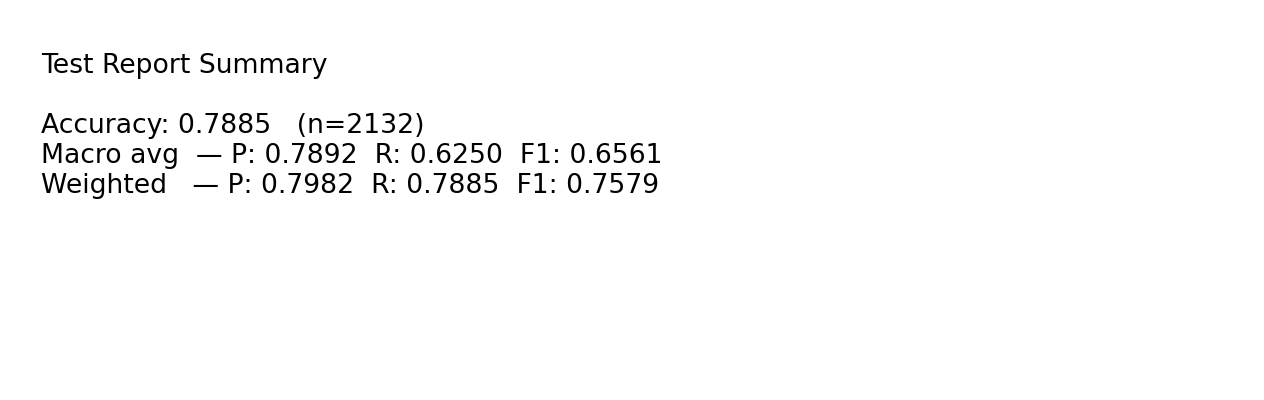

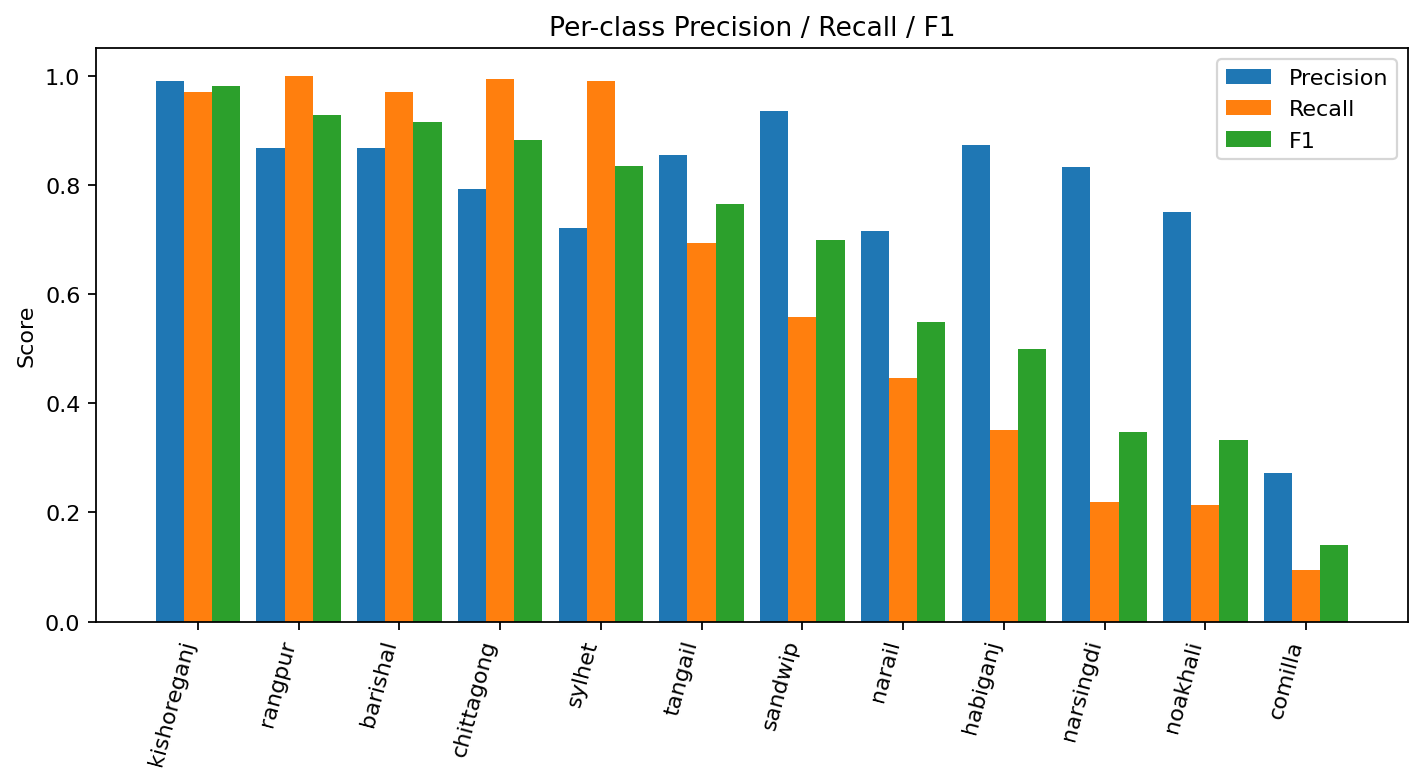

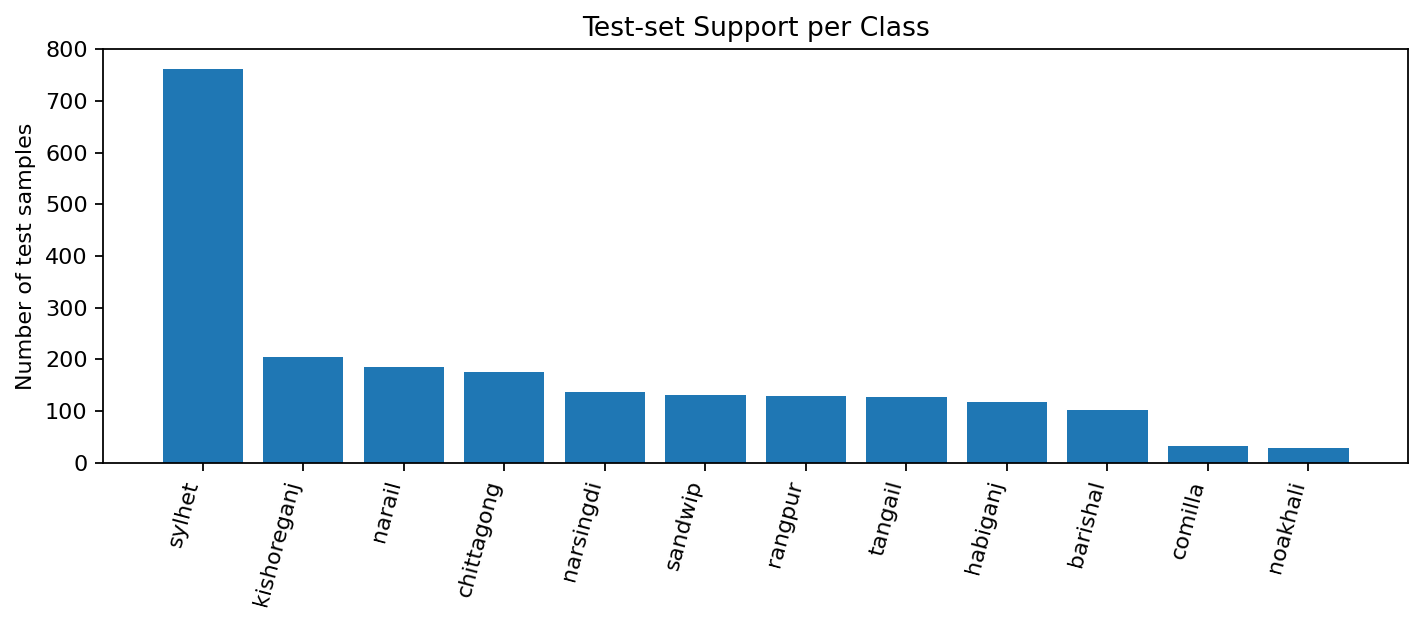

In [ ]:
# Visualize sklearn-style classification_report saved as test_report.txt
# - Makes: (1) summary panel (accuracy/macro/weighted), (2) per-class bar chart (P/R/F1), (3) support bar chart

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === set this ===
RUN_DIR = Path("/Users/farhanaakter/ProjectML/artifacts/runs/20260209_183210_embed_linear_svc")
REPORT_PATH = RUN_DIR / "test_report.txt"

TOP_N = 20      # show top N classes by F1 if there are many
DPI = 160

def parse_sklearn_report(text: str) -> pd.DataFrame:
    """
    Parse sklearn classification_report text into a dataframe with columns:
    label, precision, recall, f1-score, support
    """
    lines = [ln.rstrip() for ln in text.splitlines() if ln.strip()]
    header_idx = None
    for i, ln in enumerate(lines):
        if "precision" in ln and "recall" in ln and "f1-score" in ln:
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find classification_report header row.")

    rows = []
    for ln in lines[header_idx + 1:]:
        if set(ln.strip()) == {"-"}:
            continue

        # accuracy row: "accuracy                           0.7885      2132"
        if ln.strip().startswith("accuracy"):
            parts = ln.split()
            if len(parts) >= 3:
                rows.append({
                    "label": "accuracy",
                    "precision": np.nan,
                    "recall": np.nan,
                    "f1-score": float(parts[-2]),
                    "support": float(parts[-1]),
                })
            continue

        parts = ln.split()
        if len(parts) < 5:
            continue

        tail = parts[-4:]
        try:
            prec, rec, f1, sup = map(float, tail)
        except ValueError:
            continue

        label = " ".join(parts[:-4])
        rows.append({"label": label, "precision": prec, "recall": rec, "f1-score": f1, "support": sup})

    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("Parsed report is empty. Check formatting of test_report.txt.")
    return df

def plot_summary(df: pd.DataFrame, title: str):
    def get_row(name):
        r = df[df["label"] == name]
        return r.iloc[0].to_dict() if len(r) else None

    acc = get_row("accuracy")
    macro = get_row("macro avg")
    weighted = get_row("weighted avg")

    fig, ax = plt.subplots(figsize=(8, 2.6), dpi=DPI)
    ax.axis("off")

    lines = [title, ""]
    if acc:
        lines.append(f"Accuracy: {acc['f1-score']:.4f}   (n={int(acc['support'])})")
    if macro:
        lines.append(f"Macro avg  — P: {macro['precision']:.4f}  R: {macro['recall']:.4f}  F1: {macro['f1-score']:.4f}")
    if weighted:
        lines.append(f"Weighted   — P: {weighted['precision']:.4f}  R: {weighted['recall']:.4f}  F1: {weighted['f1-score']:.4f}")

    ax.text(0.02, 0.9, "\n".join(lines), va="top", ha="left", fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_per_class_metrics(df: pd.DataFrame, top_n: int = TOP_N):
    # keep only actual classes
    class_df = df[~df["label"].isin(["accuracy", "macro avg", "weighted avg"])].copy()
    class_df = class_df.sort_values("f1-score", ascending=False)

    if len(class_df) > top_n:
        plot_df = class_df.head(top_n).copy()
        suffix = f"(Top {top_n} by F1)"
    else:
        plot_df = class_df
        suffix = ""

    labels = plot_df["label"].astype(str).tolist()
    x = np.arange(len(labels))
    w = 0.28

    fig_w = max(9, min(18, 0.5 * len(labels)))
    fig, ax = plt.subplots(figsize=(fig_w, 5), dpi=DPI)

    ax.bar(x - w, plot_df["precision"].to_numpy(), width=w, label="Precision")
    ax.bar(x,      plot_df["recall"].to_numpy(),    width=w, label="Recall")
    ax.bar(x + w,  plot_df["f1-score"].to_numpy(),  width=w, label="F1")

    ax.set_ylim(0, 1.05)
    ax.set_title(f"Per-class Precision / Recall / F1 {suffix}".strip())
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=75, ha="right")
    ax.set_ylabel("Score")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_support(df: pd.DataFrame, top_n: int = TOP_N):
    class_df = df[~df["label"].isin(["accuracy", "macro avg", "weighted avg"])].copy()
    class_df = class_df.sort_values("support", ascending=False)

    if len(class_df) > top_n:
        plot_df = class_df.head(top_n).copy()
        suffix = f"(Top {top_n} by support)"
    else:
        plot_df = class_df
        suffix = ""

    labels = plot_df["label"].astype(str).tolist()
    x = np.arange(len(labels))

    fig_w = max(9, min(18, 0.5 * len(labels)))
    fig, ax = plt.subplots(figsize=(fig_w, 4), dpi=DPI)

    ax.bar(x, plot_df["support"].to_numpy())
    ax.set_title(f"Test-set Support per Class {suffix}".strip())
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=75, ha="right")
    ax.set_ylabel("Number of test samples")
    plt.tight_layout()
    plt.show()

# === RUN ===
text = REPORT_PATH.read_text(encoding="utf-8", errors="ignore")
df = parse_sklearn_report(text)

plot_summary(df, "Test Report Summary")
plot_per_class_metrics(df)
plot_support(df)


## Justification for Using a “Preferred Dialects” Set
Although the model is trained on all available dialect labels, the test results show that performance is not uniform across classes. Some dialects are recognized with consistently high reliability (strong recall/F1 and a clear diagonal in the confusion matrix), while others are frequently confused with higher-frequency dialects. Because dialect identification is a user-facing prediction task, reliability matters more than simply “supporting” many labels.
For this reason, I define a preferred dialect subset for practical prediction:

*Rangpur, Chittagong, Sylhet, Barishal, Kishoreganj, Narail, and Sandwip.*

This subset was chosen because these dialects demonstrated the most stable and trustworthy behavior on the held-out test set. In particular:
1. They show high true-positive identification rates (strong diagonal values in the normalized confusion matrix).
2. Their predictions are less affected by systematic collapse into another dialect label (a failure mode observed more strongly for several non-preferred dialects).
3. Their evaluation scores indicate that the model is more dependable for these classes, making them appropriate for real user recommendations.

In short, the preferred set reflects a responsible deployment decision: the model is recommended only for dialects where its test performance indicates it can generalize reliably, rather than claiming equal confidence across all dialects.

## Future Recommendations 
The primary limitation affecting weaker dialects is the amount of training data per dialect. Some dialects have far fewer samples than others, and the model learns stronger decision boundaries for dialects with more consistent and abundant examples. This is also consistent with confusion-matrix patterns where multiple low-performing dialects are absorbed into a more dominant class.
1) Collecting More Data for Underrepresented Dialects (would require significant resources)
Future work should prioritize expanding the dataset for dialects with low support and low recall. More samples would help the model learn dialect-specific patterns that it currently fails to capture consistently.
Practical ways a larger project team could do this include:

a. gathering additional recordings from more speakers per dialect (improves generalization),
b. increasing variation in speech content and recording conditions (improves robustness),
c. ensuring consistent labeling and metadata (reduces noise).

2) Reduce Class Imbalance to Improve Fairness Across Dialects
The test set indicates that some dialects dominate the dataset distribution. When classes are imbalanced, overall accuracy can look strong while minority dialect performance remains weak. A more balanced dataset would likely improve macro level performance and reduce systematic bias toward dominant dialects.

Recommended steps:
a. target data collection specifically toward minority dialects until class counts are closer,
b. maintain balanced splits so each dialect is adequately represented in training and evaluation.

3) Scope and Constraints 
This project was completed as an individual undergraduate effort with localized infrastructure, which made large-scale data collection and balancing difficult within the available time and resources. Therefore, the project focuses on building a complete, working pipeline and then scoping the model’s recommended usage to dialects where it is currently reliable. Expanding and balancing the dataset is the most realistic and highest-impact next step for future continuation of this work.